In [1]:
import os
import os.path as op
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import scipy.stats

In [2]:
pipeline='NEARICA_behav'
ages=['9m','12m','adult']

condition_epochs={
    'exe': ['LEXT','FTGE','EXGC','EXEND'],
    'obs': ['LOBS','FTGO','OBGC','OBEND']
}

epoch_time_limits={
    'LEXT': [-1500,1000],
    'FTGE': [-500,1000],
    'EXGC': [-1000,1500],
    'EXEND': [-1500,1500],
    'LOBS': [-1500,1000],
    'FTGO': [-500,1000],
    'OBGC': [-1000,1500],
    'OBEND': [-1500,1500],
}

def load_bursts(pipeline, age):
    bursts = {
        'age': [],
        'subject': [],
        'chan': [],
        'cluster': [],
        'epoch': [],
        'fwhm_freq': [],
        'fwhm_time': [],
        'peak_adjustment': [],
        'peak_amp_base': [],
        'peak_amp_iter': [],
        'peak_freq': [],
        'peak_time': [],
        'polarity': [],
        'trial': [],
        'waveform': [],        
        'waveform_times': []
    }

    subjects=pd.read_csv(op.join('/home/bonaiuto/dev_beta_umd/data',age,'data/participants.tsv'), sep='\t')
    for subject in subjects['participant_id']:
        print('loading {}'.format(subject))
        fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,subject,'processed_data/processed_bursts.mat')
        if os.path.exists(fname):
            with h5py.File(fname, 'r') as f:
                bursts['age'].extend([age for x in list(f['bursts']['trial'])])
                bursts['subject'].extend([subject for x in list(f['bursts']['trial'])])
                bursts['chan'].extend(list(np.squeeze(f['bursts']['chan'][:])))
                bursts['cluster'].extend([u''.join(chr(c) for c in np.squeeze(f[obj_ref][:])) for obj_ref in np.squeeze(f['bursts']['cluster'][:])])
                bursts['epoch'].extend([u''.join(chr(c) for c in np.squeeze(f[obj_ref][:])) for obj_ref in np.squeeze(f['bursts']['epoch'][:])])
                bursts['fwhm_freq'].extend(list(np.squeeze(f['bursts']['fwhm_freq'][:])))
                bursts['fwhm_time'].extend(list(np.squeeze(f['bursts']['fwhm_time'][:])))
                bursts['peak_adjustment'].extend(list(np.squeeze(f['bursts']['peak_adjustment'][:])))
                bursts['peak_amp_base'].extend(list(np.squeeze(f['bursts']['peak_amp_base'][:])))
                bursts['peak_amp_iter'].extend(list(np.squeeze(f['bursts']['peak_amp_iter'][:])))
                bursts['peak_freq'].extend(list(np.squeeze(f['bursts']['peak_freq'][:])))
                bursts['peak_time'].extend(list(np.squeeze(f['bursts']['peak_time'][:])))
                bursts['polarity'].extend(list(np.squeeze(f['bursts']['polarity'][:])))
                bursts['trial'].extend(list(np.squeeze(f['bursts']['trial'][:])))
                for i in range(f['bursts']['waveform'][:,:].shape[1]):
                    bursts['waveform'].append(f['bursts']['waveform'][:,i])
                bursts['waveform_times']=f['bursts']['waveform_times'][:]
                
    bursts['age']=np.array(bursts['age'])
    bursts['subject']=np.array(bursts['subject'])
    bursts['chan']=np.array(bursts['chan'])
    bursts['cluster']=np.array(bursts['cluster'])
    bursts['epoch']=np.array(bursts['epoch'])
    bursts['fwhm_freq']=np.array(bursts['fwhm_freq'])
    bursts['fwhm_time']=np.array(bursts['fwhm_time'])
    bursts['peak_adjustment']=np.array(bursts['peak_adjustment'])
    bursts['peak_amp_base']=np.array(bursts['peak_amp_base'])
    bursts['peak_amp_iter']=np.array(bursts['peak_amp_iter'])
    bursts['peak_freq']=np.array(bursts['peak_freq'])
    bursts['peak_time']=np.array(bursts['peak_time'])
    bursts['polarity']=np.array(bursts['polarity'])
    bursts['trial']=np.array(bursts['trial'])
    bursts['waveform']=np.array(bursts['waveform'])
    bursts['waveform_times']=np.array(bursts['waveform_times'])
    
    return bursts

def overlap(a,b):
    o=(a[0]<=b[0] and b[0]<=a[1]) or (b[0]<=a[0] and a[0]<=b[1])
    return o

In [3]:
age_bursts={}
for age in ages:
    age_bursts[age]=load_bursts(pipeline,age)

loading sub-010
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading sub-030
loading sub-031
loading sub-032
loading sub-033
loading sub-036
loading sub-037
loading sub-038
loading sub-041
loading sub-042
loading sub-043
loading sub-044
loading sub-001
loading sub-002
loading sub-003
loading sub-004
loading sub-005
loading sub-006
loading sub-007
loading sub-008
loading sub-009
loading sub-010
loading sub-011
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-017
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-022
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading sub-030
loading sub-031
loading sub-032
loading sub-033
loading sub-001
loading 

In [4]:
age_itis={}
for age in ages:
    age_itis[age]=[]
    
    bursts=age_bursts[age]

    subjects=np.unique(bursts['subject'])
    epochs=np.unique(bursts['epoch'])

    for s_idx,subject in enumerate(subjects):
        subj_itis=[]
        subj_rows=(bursts['subject']==subject)
        for epoch in epochs:
            epoch_rows=(subj_rows) & (bursts['epoch']==epoch)

            trials=np.unique(bursts['trial'][epoch_rows])
            for trial in trials:
                trial_rows=(epoch_rows) & (bursts['trial']==trial)

                chans=np.unique(bursts['chan'][trial_rows])
                for chan in chans:
                    chan_rows=np.where((trial_rows) & (bursts['chan']==chan))[0]                        
                    peak_times=np.sort(bursts['peak_time'][chan_rows])
                    peak_diff=np.diff(peak_times)
                    subj_itis.extend(peak_diff.tolist())
        age_itis[age].append(subj_itis)

In [5]:
age_cvs={}
for age in ages:
    age_cvs[age]=np.zeros(len(age_itis[age]))
    for s_idx in range(len(age_itis[age])):
        ISIs=np.array(age_itis[age][s_idx])
        age_cvs[age][s_idx]=np.std(ISIs)/np.mean(ISIs)

In [6]:
age_shuffled_cvs={}
n_shuffles=1000
for age in ages:
    age_shuffled_cvs[age]=[]
    
    for i in range(n_shuffles):    
        bursts=age_bursts[age]
        
        subjects=np.unique(bursts['subject'])
        epochs=np.unique(bursts['epoch'])

        for s_idx,subject in enumerate(subjects):
            subj_itis=[]
            subj_rows=(bursts['subject']==subject)
            for epoch in epochs:
                epoch_rows=(subj_rows) & (bursts['epoch']==epoch)

                if np.any(epoch_rows):
                    min_time=np.min(bursts['peak_time'][epoch_rows])
                    max_time=np.max(bursts['peak_time'][epoch_rows])

                    trials=np.unique(bursts['trial'][epoch_rows])
                    for trial in trials:
                        trial_rows=(epoch_rows) & (bursts['trial']==trial)

                        chans=np.unique(bursts['chan'][trial_rows])
                        for chan in chans:
                            chan_rows=np.where((trial_rows) & (bursts['chan']==chan))[0]                        
                            peak_times=np.random.uniform(low=min_time, high=max_time, size=len(chan_rows))
                            peak_diff=np.diff(np.sort(peak_times))
                            subj_itis.extend(peak_diff.tolist())
            subj_itis=np.array(subj_itis)
            cv=np.std(subj_itis)/np.mean(subj_itis)
            age_shuffled_cvs[age].append(cv)
        

9m: 0.63-0.74, M=0.69, SD=0.02, 0 insignificant
12m: 0.61-0.76, M=0.70, SD=0.03, 0 insignificant
adult: 0.52-0.79, M=0.70, SD=0.06, 0 insignificant


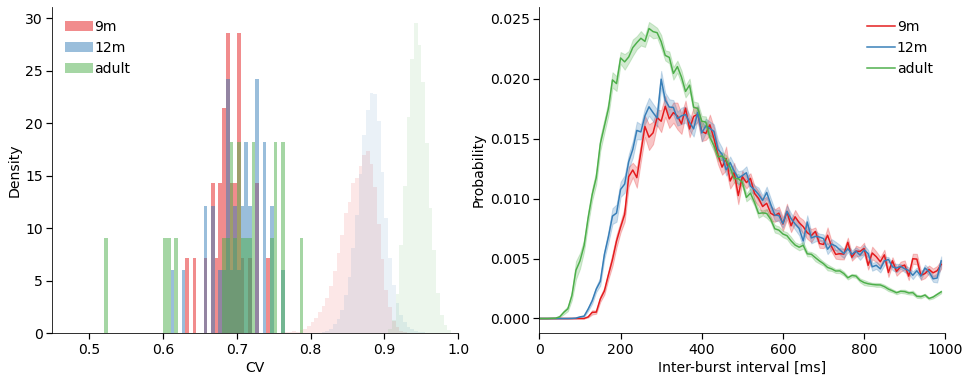

In [7]:
ages=['9m','12m','adult']
age_colors=np.array([[228,26,28],[55,126,184],[77,175,74]])/255.0

plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)

bins=np.arange(0,1,0.005)
for age_idx,age in enumerate(ages):
    cvs=age_cvs[age]
    shuffled_cvs=np.array(age_shuffled_cvs[age])
    
    m = shuffled_cvs.mean() 
    s = shuffled_cvs.std() 
    dof = len(shuffled_cvs)-1 
    confidence = 0.95
    t_crit = np.abs(scipy.stats.t.ppf((1-confidence)/2,dof))
    CI=(m-s*t_crit/np.sqrt(len(shuffled_cvs)), m+s*t_crit/np.sqrt(len(shuffled_cvs))) 
    n_insig=len(np.where(cvs>CI[0])[0])
    
    print('{}: {:.2f}-{:.2f}, M={:.2f}, SD={:.2f}, {} insignificant'.format(age,np.min(cvs),np.max(cvs),np.mean(cvs),np.std(cvs), n_insig))
    _=plt.hist(cvs,bins,alpha=.5, density=True, color=age_colors[age_idx], label=age)
    
    _=plt.hist(shuffled_cvs,bins,alpha=.1, density=True, color=age_colors[age_idx])
    
plt.legend()
plt.xlabel('CV')
plt.ylabel('Density')
plt.xlim([0.45,1.0])


plt.subplot(1,2,2)                         # Plot the data and the model,
bins = np.arange(0, 1010, 10)           # Define 1 ms bins.

for age_idx,age in enumerate(ages):
    probs=np.zeros((len(age_itis[age]),len(bins)-1))
    for s_idx in range(len(age_itis[age])):
        ISIs=np.array(age_itis[age][s_idx])
        counts, _ = np.histogram(ISIs, bins)  # Compute histogram,
        probs[s_idx,:] = counts / len(ISIs)             # ... convert to probability,
        
    m_prob=np.mean(probs,axis=0)
    se_prob=np.std(probs,axis=0)/np.sqrt(probs.shape[0])
    plt.plot(bins[:-1], m_prob, label=age, color=age_colors[age_idx])     # ... and plot probability.
    plt.fill_between(bins[:-1], m_prob-se_prob, m_prob+se_prob, alpha=0.25, color=age_colors[age_idx])

plt.xlim([0, 1000])                       # xlim from 0 to 200 ms.
plt.xlabel('Inter-burst interval [ms]')                        # Label the axes.
plt.ylabel('Probability')
plt.legend()



plt.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure4.svg')
plt.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure4.png')

